In [1]:
!pip install  transformers
!pip install datasets
import subprocess
import sys
import torch
import transformers
import datasets
import huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
is_colab = "google.colab" in sys.modules
is_kaggle = "kaggle_secrets" in sys.modules
is_gpu_available = torch.cuda.is_available()

In [3]:
is_colab = "google.colab" in sys.modules
is_kaggle = "kaggle_secrets" in sys.modules
# torch-scatter binaries depend on the torch and CUDA version, so we define the
# mappings here for Colab & Kaggle
torch_to_cuda = {"1.10.0": "cu113", "1.9.0": "cu111", "1.9.1": "cu111"}
print("⏳ Installing base requirements ...")
cmd = ["python", "-m", "pip", "install", "-r"]
cmd.append("/content/Notebooks/requirements.txt")
print(cmd)
process_install = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

if process_install.returncode != 0:
    print(process_install.returncode)
    raise Exception("😭 Failed to install base requirements")
else:
    print("✅ Base requirements installed!")
print("⏳ Installing Git LFS ...")
process_lfs = subprocess.run(["apt", "install", "git-lfs"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
if process_lfs.returncode == -1:
    raise Exception("😭 Failed to install Git LFS and soundfile")
else:
    print("✅ Git LFS installed!")

transformers_cmd = "python -m pip install transformers==4.13.0".split()
process_scatter = subprocess.run(
    transformers_cmd,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
)


⏳ Installing base requirements ...
['python', '-m', 'pip', 'install', '-r', '/content/Notebooks/requirements.txt']
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


In [4]:
def setup_environment():
    # Check if we have a GPU
    if not is_gpu_available:
        print("No GPU was detected! This notebook can be *very* slow without a GPU 🐢")
        if is_colab:
            print("Go to Runtime > Change runtime type and select a GPU hardware accelerator.")
        if is_kaggle:
            print("Go to Settings > Accelerator and select GPU.")
    # Give visibility on versions of the core libraries
    display_library_version(transformers)
    display_library_version(datasets)
    # Disable all info / warning messages
    transformers.logging.set_verbosity_error()
    datasets.logging.set_verbosity_error()
    # Logging is only available for the chapters that don't depend on Haystack
    if huggingface_hub.__version__ == "0.0.19":
        huggingface_hub.logging.set_verbosity_error()
    # Use O'Reilly style for plots
    # set_plot_style()

In [5]:
def display_library_version(library):
    print(f"Using {library.__name__} v{library.__version__}")

In [6]:
setup_environment()

No GPU was detected! This notebook can be *very* slow without a GPU 🐢
Go to Runtime > Change runtime type and select a GPU hardware accelerator.
Using transformers v4.13.0
Using datasets v2.3.2


We want to work on the emotions so download emotion dataset from the datasets

In [7]:
from datasets import load_dataset
emotions = load_dataset("emotion")
# dataset_url = "https://dl.dropbox.com/s/0eundmrr3n6hbf0/twitter_train.txt"
# !wget {dataset_url}

# !head -n 1 twitter_train.txt
# emotions = load_dataset("csv", data_files="twitter_train.txt", sep=";", 
#                               names=["text", "label"])

  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

Check the number of records in training dataset. Get all the elemenets in train dataset in train_ds.

In [9]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

Check the number of records in the validation dataset

In [10]:
train_ds = emotions["validation"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 2000
})

Get the elements in the training dataset. Here we can see that label which is a feature is a number and not the actual emotion type.

In [11]:
train_ds[0]

{'text': 'im feeling quite sad and sorry for myself but ill snap out of it soon',
 'label': 0}

To understand column in the dataset

In [12]:
train_ds.column_names

['text', 'label']

to understand the features in the dataset

In [13]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


There are 16000 elements in the train_ds so printing 20 to 25 lements and then printing top 5 elements. Check the labels. They are different

In [14]:
print(train_ds[20:25])

{'text': ['i just know to begin with i am going to feel shy about it', 'i feel try to tell me im ungrateful tell me im basically the worst daughter sister in the world', 'i feel that it is something that will never really be resolved', 'i just feel like all my efforts are in vain and a waste of time', 'i feel absolutely foolish for allowing myself to actually believe that this might be it for us the month weve been praying so hard for'], 'label': [4, 0, 1, 0, 0]}


In [15]:
print(train_ds[:5])

{'text': ['im feeling quite sad and sorry for myself but ill snap out of it soon', 'i feel like i am still looking at a blank canvas blank pieces of paper', 'i feel like a faithful servant', 'i am just feeling cranky and blue', 'i can have for a treat or if i am feeling festive'], 'label': [0, 0, 2, 3, 1]}


Data visualization becomes bit complex with Datasets. It is often convenient to convert a dataset object to a Pandas DataFrame, so we can access high-level APIs for data visualization. Tough, datasets provide a lot of low-level functionality to slice and dice data.

In [16]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


The column headers have been preserved, after the use of pandas and the first few rows match our previous views of the data. However, the labels are represented as integers, so let's use the `int2str()` method of the `label` feature to create a new column in our `DataFrame` with the corresponding label names. "int2str" is a hugging face function 
https://huggingface.co/docs/datasets/v1.10.2/package_reference/main_classes.html#datasets.ClassLabel.int2str

Basically it converts the value of interger label to corresponding string.

In [17]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)


df["label_name"] = df["label"].apply(label_int2str)

df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


Understanding the distribution of dataset by the category.

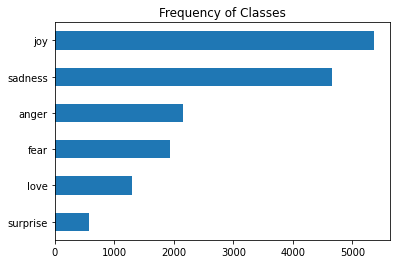

In [18]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

*Transformer* models have a maximum input sequence length that is referred to as the _maximum context size_. For applications using DistilBERT, the maximum context size is 512 tokens, which amounts to a few paragraphs of text. As we'll see in the next section, a token is an atomic piece of text; for now, we'll treat a token as a single word. We can get a rough estimate of tweet lengths per emotion by looking at the distribution of words per tweet:

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


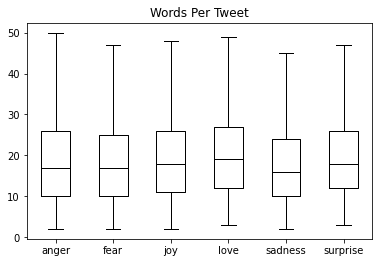

In [19]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

From the plot we see that for each emotion, most tweets are around 15 words long and the longest tweets are well below DistilBERT's maximum context size. Texts that are longer than a model's context size need to be truncated, which can lead to a loss in performance if the truncated text contains crucial information; in this case, it looks like that won't be an issue.

In [20]:
# Here earlier format was set as pandas for using as dataframe so now it is reset.
emotions.reset_format()

DistilBERT transformer model cannot receive raw strings as input; instead, they assume the text has been tokenized and encoded as numerical vectors. Tokenization is the step of breaking down a string into the atomic units used in the model. There are several tokenization strategies one can adopt, and the optimal splitting of words into subunits is usually learned from the corpus. Before looking at the tokenizer used for DistilBERT, let's consider two extreme cases: character and word tokenization.

The basic idea behind subword tokenization is to combine the best aspects of character and word tokenization. On the one hand, we want to split rare words into smaller units to allow the model to deal with complex words and misspellings. On the other hand, we want to keep frequent words as unique entities so that we can keep the length of our inputs to a manageable size. The main distinguishing feature of subword tokenization (as well as word tokenization) is that it is learned from the pretraining corpus using a mix of statistical rules and algorithms.

There are several subword tokenization algorithms that are commonly used in NLP, but let's start with WordPiece,footnote:[M. Schuster and K. Nakajima, "Japanese and Korean Voice Search," 2012 IEEE International Conference on Acoustics, Speech and Signal Processing (2012): 5149–5152, https://doi.org/10.1109/ICASSP.2012.6289079.] which is used by the BERT and DistilBERT tokenizers. The easiest way to understand how WordPiece works is to see it in action. image:images/logo.png[hf,13,13] Transformers provides a convenient AutoTokenizer class that allows you to quickly load the tokenizer associated with a pretrained model—we just call its from_pretrained() method, providing the ID of a model on the Hub or a local file path. Let's start by loading the tokenizer for DistilBERT:

In [21]:
# hide_output
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [22]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [23]:
print(tokenize(emotions["train"][:5]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102], [101, 10047, 9775, 1037, 3371, 2000, 2695, 1045, 2514, 20505, 3308, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2572, 2412, 3110, 16839, 9080, 12863, 2055, 1996, 13788, 1045, 2097, 2113, 2008, 2009, 2003, 2145, 2006, 1996, 3200, 102, 0], [101, 1045, 2572, 3110, 24665, 7140, 11714, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}


Here we can see the result of padding: the first element of input_ids is shorter than the second, so zeros have been added to that element to make them the same length. These zeros have a corresponding [PAD] token in the vocabulary, and the set of special tokens also includes the [CLS] and [SEP] tokens that we encountered earlier:

In [24]:
#hide_input
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))


# Python has the ability to index from the end of a list. Hence, x[-1] refers to the last element, x refers to the second to last element, etc.
data = sorted(tokens2ids, key=lambda x : x[-1])

df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


In [25]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [26]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


text: Actual text from data
label: numeric value of emotion
input_ids: 
The attention mask: is a binary tensor indicating the position of the padded indices so that the model does not attend to them

In [27]:
print(emotions_encoded["train"][0])

{'text': 'i didnt feel humiliated', 'label': 0, 'input_ids': [101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


We will use another convenient auto class from image:images/logo.png[hf,13,13] Transformers called AutoModel. Similar to the AutoTokenizer class, AutoModel has a from_pretrained() method to load the weights of a pretrained model. Let's use this method to load the DistilBERT checkpoint:

In [28]:
# hide_output
from transformers import AutoModel
#  A checkpoint corresponds to the set of weights that are loaded into a given transformer architecture.
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# the text is tokenized and represented as one-hot vectors called token encodings
# The AutoModel class converts the token encodings to embeddings, and then feeds them through the encoder stack to return the hidden states.
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [29]:
# from transformers import TFAutoModel

# tf_model = TFAutoModel.from_pretrained(model_ckpt)

In [39]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [31]:
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])

In [34]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [40]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [43]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [44]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [47]:
!pip install umap-learn
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.6 MB/s 
     |████████████████████████████████| 1.1 MB 49.0 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=27ca2b0ec12b8f892c90793a0e4aff2fa4173234953addcb43b5668b1535b412
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=0a4c11c8f15f8bd51081aa8cce3c878918f3d91fbcdb050e3d247e9d663ea341
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


,X,Y,label
0,4.253084,6.805964,0
1,-2.882774,5.780232,0
2,5.409073,3.208952,3
3,-2.351638,3.189438,2
4,-3.215258,3.850488,3


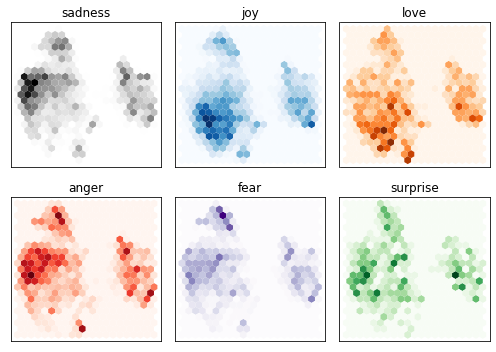

In [48]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [49]:
#hide_output
# We increase `max_iter` to guarantee convergence 
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [50]:
lr_clf.score(X_valid, y_valid)

0.633

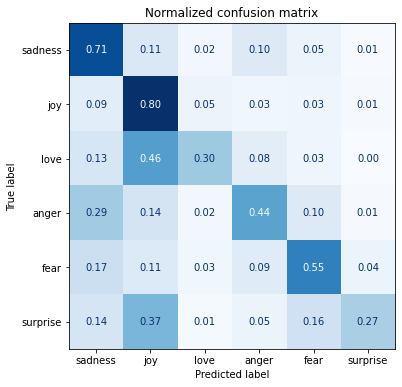

In [51]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

In [52]:
# hide_output
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

In [53]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [55]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [56]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
# model_name = f"{model_ckpt}-finetuned-emotion"
model_name = f"newsmodelclassification"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True, 
                                  log_level="error")

In [58]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

/content/newsmodelclassification is already a clone of https://huggingface.co/aatmasidha/newsmodelclassification. Make sure you pull the latest changes with `repo.git_pull()`.


KeyboardInterrupt: ignored

In [ ]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [ ]:
preds_output.metrics

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)

In [ ]:
plot_confusion_matrix(y_preds, y_valid, labels)

In [ ]:
#hide_output
from transformers import TFAutoModelForSequenceClassification

tf_model = (TFAutoModelForSequenceClassification
            .from_pretrained(model_ckpt, num_labels=num_labels))

In [ ]:
# The column names to convert to TensorFlow tensors
tokenizer_columns = tokenizer.model_input_names

tf_train_dataset = emotions_encoded["train"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=True,
    batch_size=batch_size)
tf_eval_dataset = emotions_encoded["validation"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=False,
    batch_size=batch_size)

In [ ]:
#hide_output
import tensorflow as tf

tf_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy())

tf_model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=2)

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns   
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

In [ ]:
#hide_output
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

In [ ]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [ ]:
#hide_output
df_test.sort_values("loss", ascending=False).head(10)

In [ ]:
#hide_output
trainer.push_to_hub(commit_message="Training completed!")